# Model Testing

The purpose of this notebook is to gain insights on the performance of the model on a held-out test dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

We have forked the package [rafaelpadilla/review_object_detection_metrics](https://github.com/rafaelpadilla/review_object_detection_metrics) and customized it for the purpose of this use case. If you would like to run this notebook, contact us and we will provide you with the customized files. (Note: this script does not need to be executed to train the final model).

In [2]:
!mkdir /usr/lib/python3.7/metrics
!cp -R /content/drive/MyDrive/review_object_detection_metrics-main/src /usr/lib/python3.7/metrics/src

In [3]:
!pip install PyQt5
!pip install -qU torch_snippets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.4 MB 4.2 MB/s 
     |████████████████████████████████| 59.9 MB 1.2 MB/s 
     |████████████████████████████████| 344 kB 91.2 MB/s 
     |████████████████████████████████| 49 kB 2.4 MB/s 
     |████████████████████████████████| 78 kB 3.9 MB/s 
     |████████████████████████████████| 58 kB 6.3 MB/s 
     |████████████████████████████████| 235 kB 30.7 MB/s 
     |████████████████████████████████| 51 kB 8.4 MB/s 


In [4]:
import copy
import glob
import torch
import time
import statistics
import cv2
import pandas as pd
import IPython
import matplotlib.pyplot as plt

from os.path import join
from torch_snippets import *
from PIL import Image
from metrics.src.evaluators import coco_evaluator, pascal_voc_evaluator
from metrics.src.bounding_box import BoundingBox
from metrics.src.utils.enumerators import BBFormat, BBType, CoordinatesType, MethodAveragePrecision

# Load data

In [5]:
width, height = 1000, 1000
IMAGE_ROOT = '/content/drive/MyDrive/data/euro-coin-dataset-master'
output_models = '/content/drive/MyDrive/outputs/models'
rootdir = '/content/drive/MyDrive/data'
batch_size = 1 # batch size set to 1 so that each predictions must not be unpacked everytime

In [6]:
df_test = pd.read_csv(os.path.join(rootdir, 'test.csv'))
df_test.head(10)

,folder,filename,width,height,depth,segmented,name,pose,truncated,difficult,xmin,ymin,xmax,ymax
0,50,20210327_180728.jpg,3024,3024,3,0,50,50,50,50,1955,1474,2488,1996
1,50,20210327_180728.jpg,3024,3024,3,0,50,50,50,50,1131,684,1621,1197
2,50,20210327_180728.jpg,3024,3024,3,0,50,50,50,50,1930,874,2447,1396
3,50,20210327_180728.jpg,3024,3024,3,0,50,50,50,50,1262,1287,1765,1781
4,50,20210327_180728.jpg,3024,3024,3,0,50,50,50,50,739,1618,1246,2127
5,50,20210327_180728.jpg,3024,3024,3,0,50,50,50,50,506,1040,1009,1546
6,50,20210327_180728.jpg,3024,3024,3,0,50,50,50,50,1409,1917,1918,2427
7,5,20210328_161348.jpg,3024,3024,3,0,5,5,5,5,162,565,1065,1449
8,5,20210328_161348.jpg,3024,3024,3,0,5,5,5,5,990,212,1903,1121
9,5,20210328_161348.jpg,3024,3024,3,0,5,5,5,5,1540,927,2443,1818


In [7]:
label2target = {1: 1, 10: 2, 100: 3, 2: 4, 20: 5, 200: 6, 5: 7, 50: 8, 'background': 0}
target2label = {0: 'background', 1: 1, 2: 10, 3: 100, 4: 2, 5: 20, 6: 200, 7: 5, 8: 50}
num_classes = len(label2target)

In [8]:
def preprocess_image(img):
  img = torch.tensor(img).permute(2,0,1)
  return img.to(device).float()

In [9]:
def preprocess_traindata(img, data, target_width, target_height):
  current_width, current_height = img.size
  data[:,[0,2]] = (data[:,[0,2]] / current_width * target_width).astype(int)
  data[:,[1,3]] = (data[:,[1,3]] / current_height * target_height).astype(int)

  img = np.array(img.resize((width, height), resample=Image.BILINEAR))/255.

  return img, data

In [10]:
class CoinDataset(torch.utils.data.Dataset):
  w, h = width, height
  def __init__(self, df, image_dir=IMAGE_ROOT, transformer = None, threshold = 0.15):
    self.image_dir = image_dir
    self.files = glob.glob(IMAGE_ROOT + '/*/*')
    self.df = df
    self.image_infos = df['filename'].unique()
    self.transformer = transformer
    self.threshold = threshold

  def __getitem__(self, ix):

    #filename	pose	xmin	xmax	ymin	ymax

    # load image
    image_id = self.image_infos[ix]
    img_path = find(image_id, self.files)



    img = Image.open(img_path).convert('RGB')

    data = self.df[self.df['filename'] == image_id]
    labels = data['pose'].values.tolist()
    data = data[['xmin','ymin','xmax','ymax']].values

    if self.transformer:
      pass # not relevant since for testing data augmentation is not needed

    img, data = preprocess_traindata(img, data, self.w, self.h)

    boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
    # torch FRCNN expects ground truths as a dictionary of tensors
    target = {}
    target['boxes'] = torch.Tensor(boxes).float()
    target['labels'] = torch.Tensor([label2target[i] for i in labels]).long()
    img = preprocess_image(img)

    return img, target

  def collate_fn(self, batch):
    return tuple(zip(*batch)) 

  def __len__(self):
    return len(self.image_infos)

In [11]:
test_ds = CoinDataset(df_test)  

In [12]:
test_loader = DataLoader(test_ds, batch_size=batch_size, collate_fn=test_ds.collate_fn, drop_last=True)

# Load trained model

In [13]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model():
  model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

## MobileNet

In [14]:
model = get_model()
model.load_state_dict(
        torch.load(
            join(output_models, 'checkpoints', 'epoch_280_faster_rcnn_mobilenetv3_large.pt'),
            map_location=device
        )
    )
model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

# Test model

In [15]:
from torchvision.ops import nms
def decode_output(output):
  'convert tensors to numpy arrays'
  bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
  labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
  confs = output['scores'].cpu().detach().numpy()
  ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
  bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

  if len(ixs) == 1:
      bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
  return bbs.tolist(), confs.tolist(), labels.tolist()

## MobileNet

In [16]:
bounding_boxes_detected = []
bounding_boxes_gt = []
model.eval()

for ix, (images, targets) in enumerate(test_loader):
  images = [torch.tensor(im).type(torch.FloatTensor).to(device) for im in images]
  outputs = model(images)
  outputs = decode_output(outputs[0])

  #Detected
  for i, output in enumerate(outputs[0]):
    bb = BoundingBox(
      image_name        = str(ix),
      class_id          = outputs[2][i],
      coordinates       = output,
      type_coordinates  = CoordinatesType.ABSOLUTE,
      bb_type           = BBType.DETECTED,
      confidence        = outputs[1][i],
      format            = BBFormat.XYX2Y2
    )
    bounding_boxes_detected.append(bb)


  #Ground Truth
  for i, box in enumerate(targets[0]['boxes']):
    cls = target2label[int(targets[0]['labels'][i])]
    bb = BoundingBox(
      image_name        = str(ix),
      class_id          = cls,
      coordinates       = list(box),
      type_coordinates  = CoordinatesType.ABSOLUTE,
      bb_type           = BBType.GROUND_TRUTH,
      confidence        = None,
      format            = BBFormat.XYX2Y2
    )
    bounding_boxes_gt.append(bb)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


# COCO Benchmark

In [31]:
coco_evaluator.get_coco_summary(
    groundtruth_bbs = bounding_boxes_gt,
    detected_bbs = bounding_boxes_detected,
    small_size = 98.50850764,
    medium_size = 201.88434696
)

{'AP': 0.7872676809783735,
 'AP50': 0.9211916065413052,
 'AP75': 0.9191047768944863,
 'APlarge': 0.802838307532037,
 'APmedium': 0.7904370483635017,
 'APsmall': 0.7194059405940595,
 'AR1': 0.3142672958304689,
 'AR10': 0.8252906951747644,
 'AR100': 0.8266882107027147,
 'ARlarge': 0.8308276019878796,
 'ARmedium': 0.8271182334639391,
 'ARsmall': 0.75}

# Full COCO Benchmark

In [ ]:
df = coco_evaluator.get_coco_metrics(
        bounding_boxes_gt,
        bounding_boxes_detected,
        iou_threshold=0.5,
        area_range=(0, np.inf),
        max_dets=100,
)
df = pd.DataFrame.from_dict(df)
df.head()

,50,5,2,200,100,10,1,20
class,50,5,2,200,100,10,1,20
precision,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
recall,"[0.03571428571428571, 0.07142857142857142, 0.1...","[0.005494505494505495, 0.01098901098901099, 0....","[0.005847953216374269, 0.011695906432748537, 0...","[0.038461538461538464, 0.07692307692307693, 0....","[0.029411764705882353, 0.058823529411764705, 0...","[0.006211180124223602, 0.012422360248447204, 0...","[0.005952380952380952, 0.011904761904761904, 0...","[0.030303030303030304, 0.06060606060606061, 0...."
AP,0.960396,0.919279,0.869099,1.0,0.970297,0.978233,0.847014,0.775559
interpolated precision,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 0.9818181818181818, 0.981...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


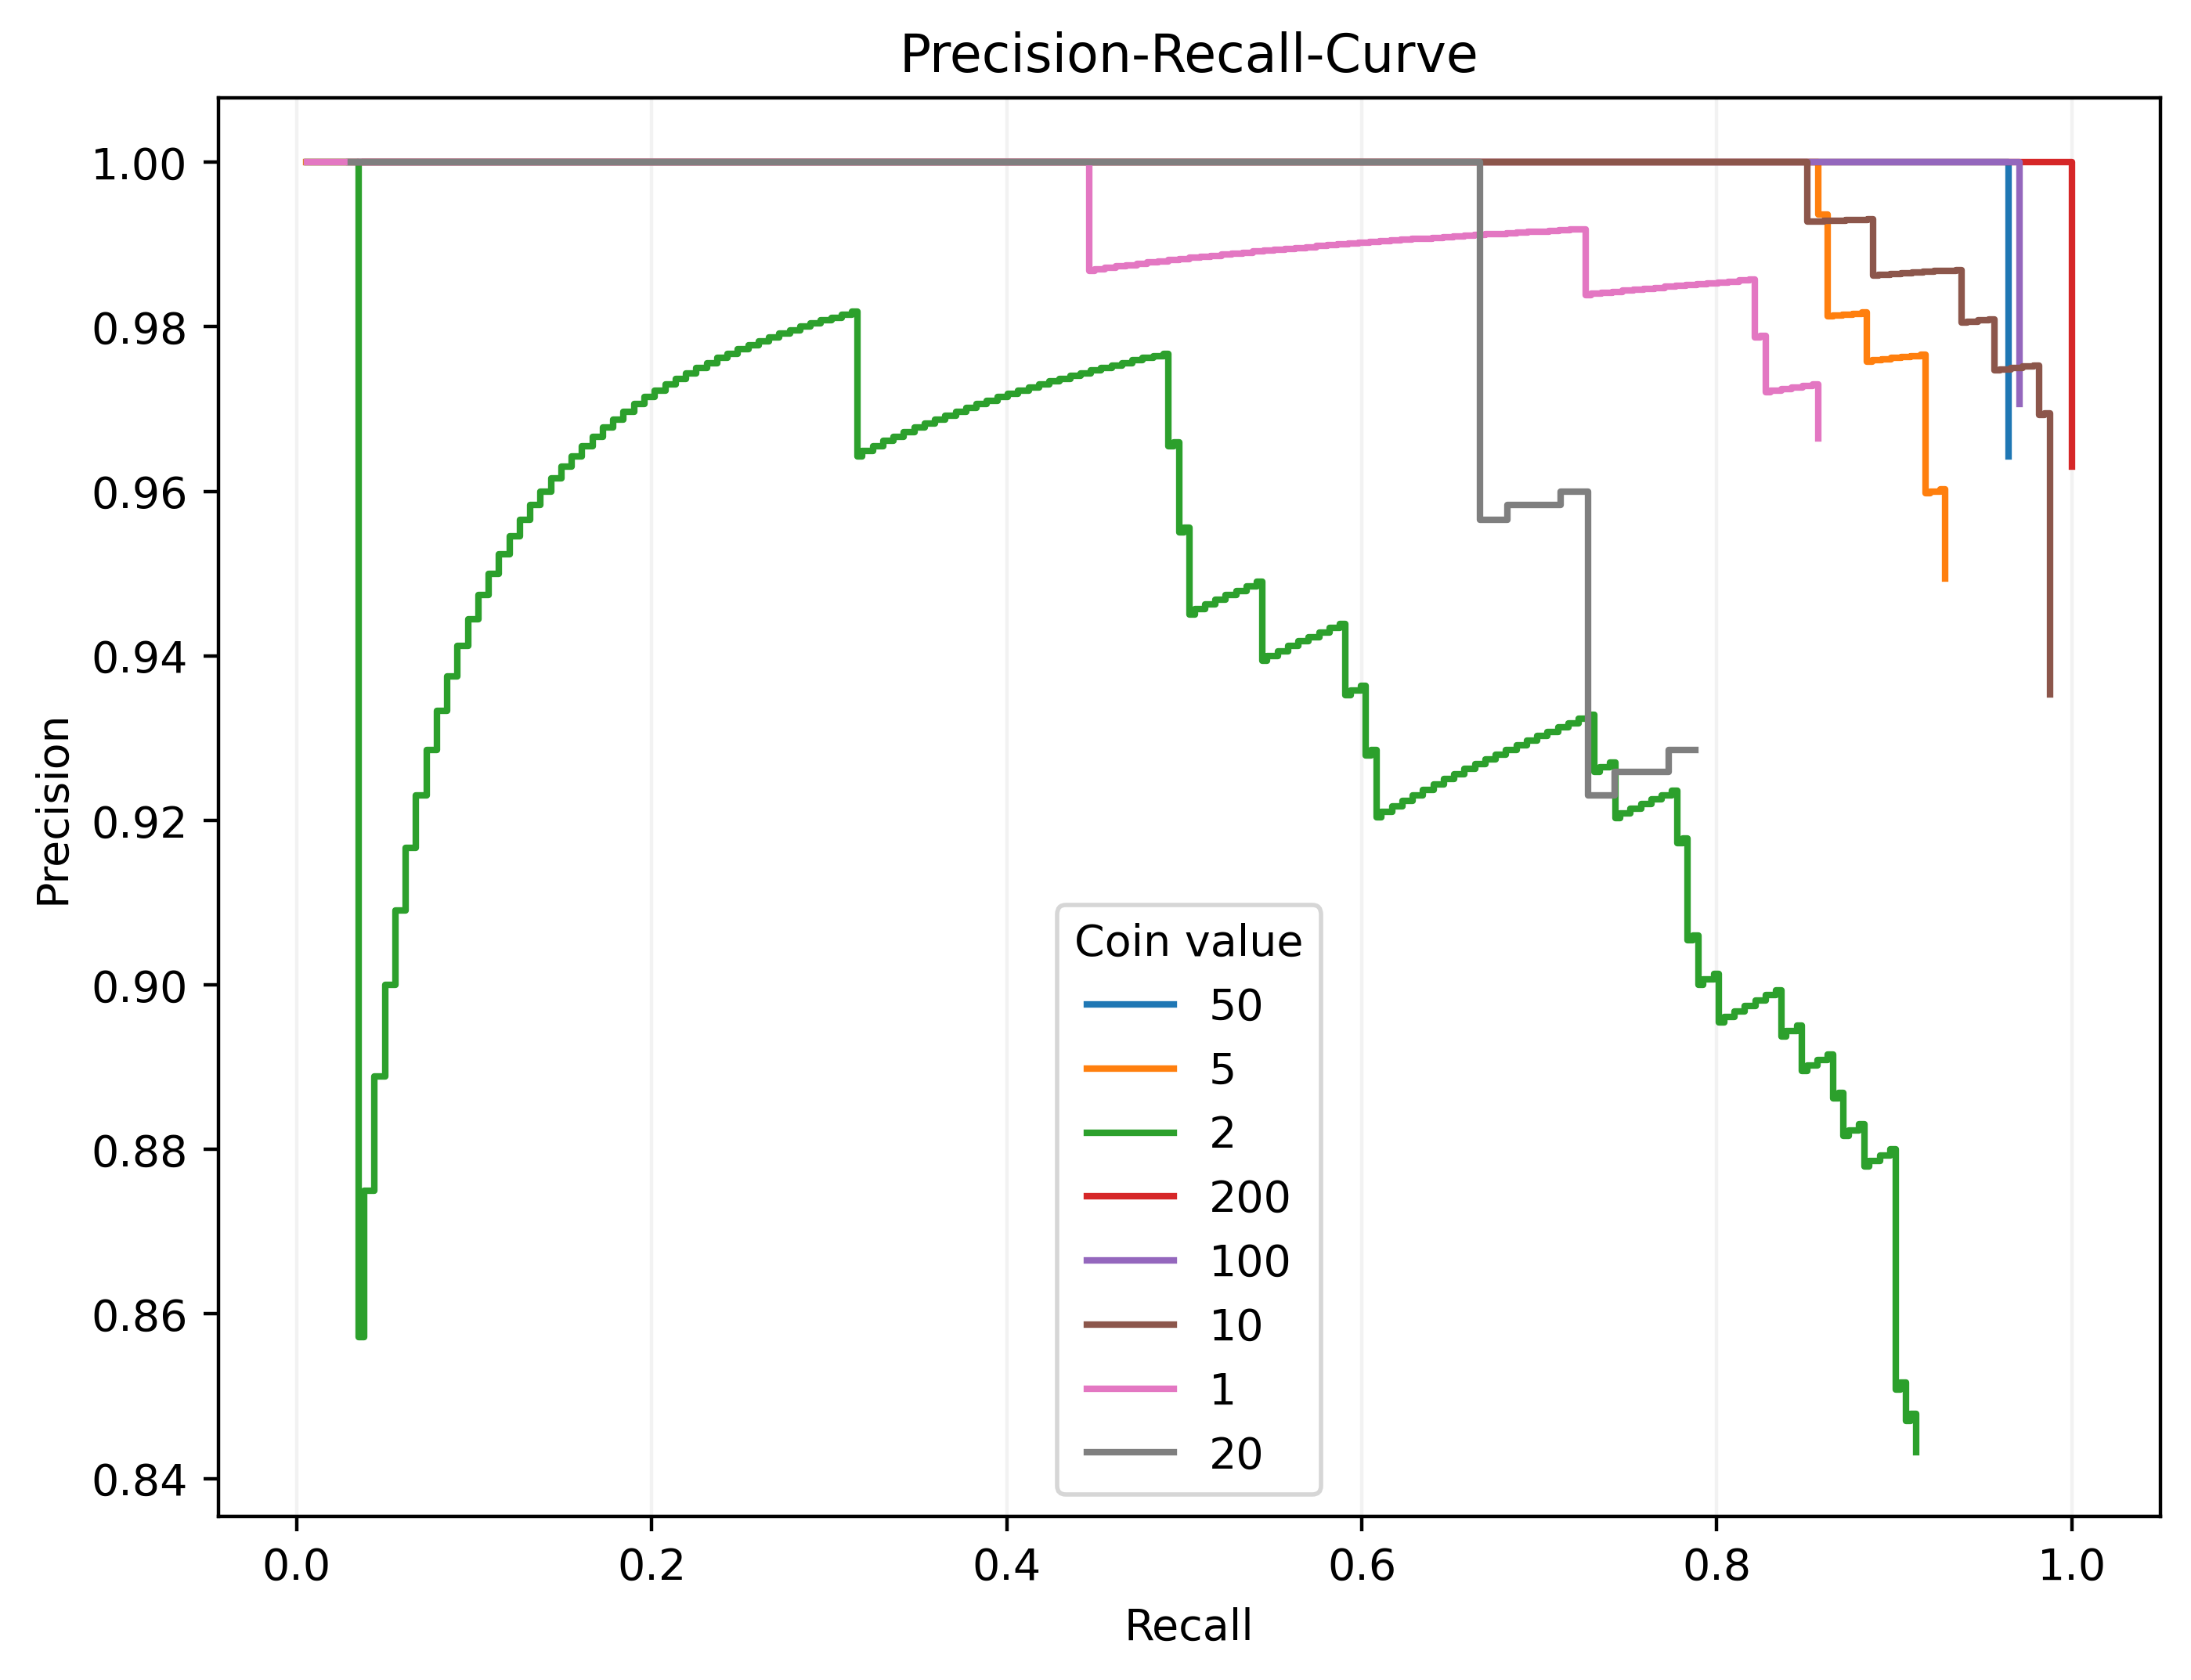

In [ ]:
plt.figure(figsize=(8, 6), dpi=400)

for column in df.columns:
  plt.step(df[column]['recall'], df[column]['precision'], where='mid', label=column)


plt.grid(axis='x', color='0.95')
plt.legend(title='Coin value')
plt.title('Precision-Recall-Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()